In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing as ppr
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc
get_ipython().run_line_magic('matplotlib', 'inline')

Import the data and pre-process 

In [3]:
bank = pd.read_csv("bank_marketing_part1_Data.csv",sep=',')

In [4]:
bank.dtypes
bank.head()
bank.columns

Index(['spending', 'advance_payments', 'probability_of_full_payment',
       'current_balance', 'credit_limit', 'min_payment_amt',
       'max_spent_in_single_shopping'],
      dtype='object')

In [5]:
bank['spending'] = bank['spending'] * 1000
bank['advance_payments'] = bank['advance_payments'] * 100
bank['current_balance'] = bank['current_balance'] * 1000
bank['credit_limit'] = bank['credit_limit'] * 10000
bank['min_payment_amt'] = bank['min_payment_amt'] * 100
bank['max_spent_in_single_shopping'] = bank['max_spent_in_single_shopping'] * 1000

Exploratory Data Analysis

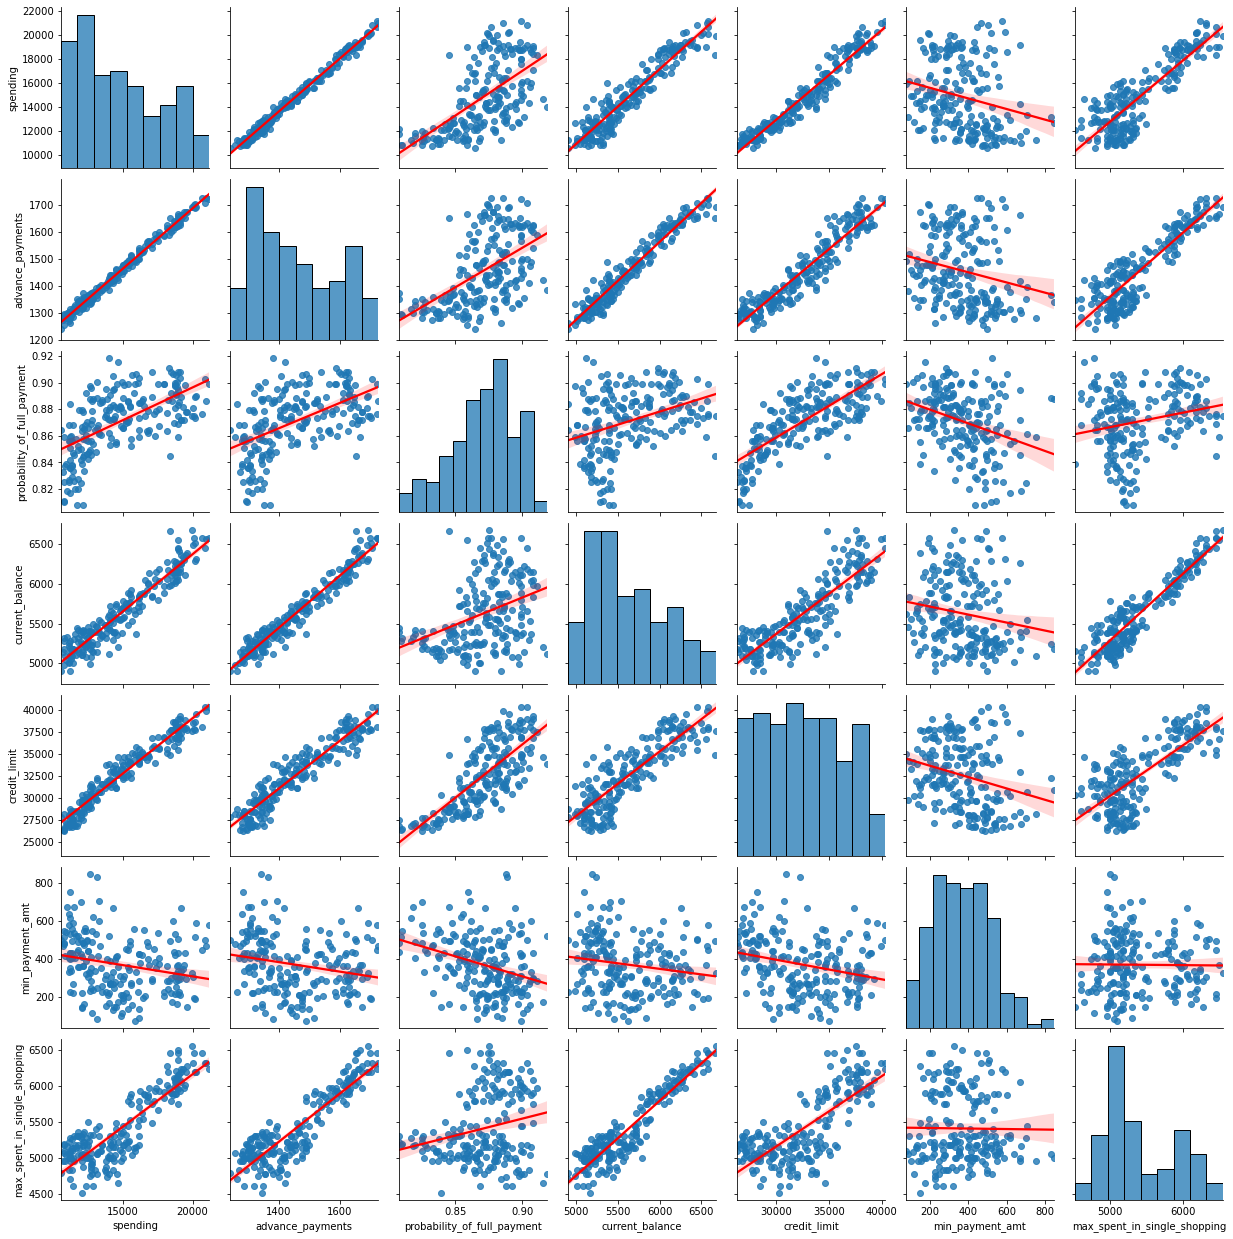

In [6]:
sns.pairplot(bank,kind='reg',plot_kws={'line_kws':{'color':'red'}})

<AxesSubplot:>

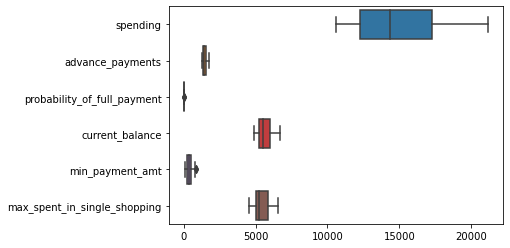

In [7]:
sns.boxplot(data=bank.loc[:,bank.columns!='credit_limit'],orient="h")

<AxesSubplot:>

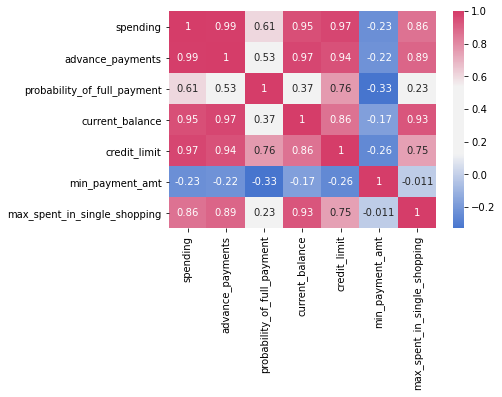

In [8]:
sns.heatmap(bank.corr(),cmap=sns.diverging_palette(256,0,sep=80,n=7,as_cmap=True),annot=True)

Scale the Data

In [9]:
scaler = ppr.StandardScaler()

In [10]:
bankscaled = scaler.fit_transform(bank)
bankscaled = pd.DataFrame(bankscaled)
bankscaled.head()

,0,1,2,3,4,5,6
0,1.754355,1.811968,0.178230,2.367533,1.338579,-0.298806,2.328998
1,0.393582,0.253840,1.501773,-0.600744,0.858236,-0.242805,-0.538582
2,1.413300,1.428192,0.504874,1.401485,1.317348,-0.221471,1.509107
3,-1.384034,-1.227533,-2.591878,-0.793049,-1.639017,0.987884,-0.454961
4,1.082581,0.998364,1.196340,0.591544,1.155464,-1.088154,0.874813


<AxesSubplot:>

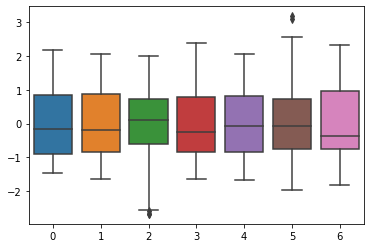

In [11]:
sns.boxplot(data=bankscaled)

# -----------First Part : Hierarcical Clustering --------------#########

In [12]:
hc = AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage="ward",compute_full_tree='auto')

In [13]:
agglmodel = hc.fit(bankscaled)

In [14]:
hclabels = agglmodel.labels_

Text(0.5, 0, 'Customers')

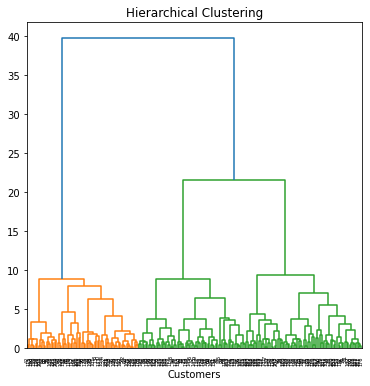

In [15]:
plt.figure(figsize =(6, 6)) 
plt.title('Hierarchical Clustering')
Dendo = shc.dendrogram(shc.linkage(bankscaled,method='ward',metric='euclidean'))
plt.xlabel('Customers')

In [16]:
pcacolms = PCA(n_components=2).fit_transform(bankscaled)

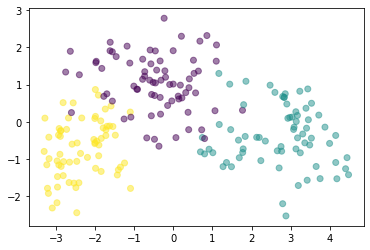

In [17]:
plt.scatter(x=pcacolms[:,0],y=pcacolms[:,1] , c= hclabels, alpha=0.5)

In [18]:
silhouette_avg = silhouette_score(bankscaled, hclabels)

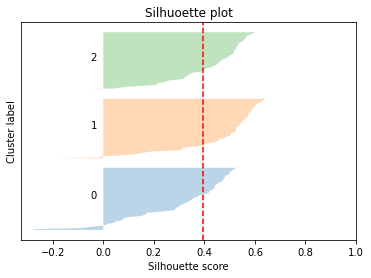

In [20]:
each_silhouette_score = silhouette_samples(bankscaled, hclabels,metric="euclidean")
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
y_lower =10

for i in range(0,3):
    ith_cluster_silhouette_values = each_silhouette_score[hclabels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,alpha=0.3)
    
    #label the silhouse plots with their cluster numbers at the middle
    ax.text(-0.05,y_lower + 0.5 * size_cluster_i,str(i))
    
    #compute the new y_lower for next plot
    y_lower = y_upper +10 
    
ax.set_title("Silhuoette plot")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster label")
    
#the vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg,color="red",linestyle="--")
    
ax.set_yticks([])
ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1])

# --------------------- Second Part : K Means-----------------------------------#

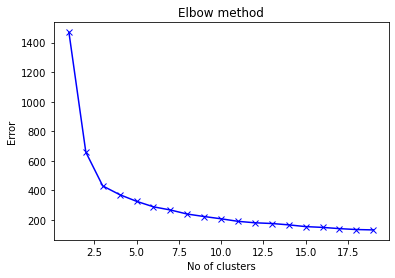

In [21]:
# WSS method
SSE =[]
for i in range(1,20):
    km = KMeans(n_clusters = i)
    km = km.fit(bankscaled)
    SSE.append(km.inertia_)

plt.plot(range(1, 20), SSE,'bx-')
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

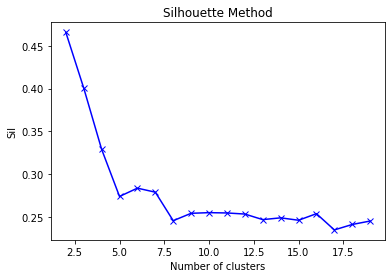

In [22]:
# Silhoutte score method
silht = []

for k in range(2, 20):
  km1 = KMeans(n_clusters = k).fit(bankscaled)  
  preds = km1.fit_predict(bankscaled)
  silht.append(silhouette_score(bankscaled, preds, metric = 'euclidean'))

plt.plot(range(2, 20), silht,'bx-')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sil')
plt.show()

## ------------Final K means with k = 3 as optimal value---------------#

In [26]:
finalkmean = KMeans(n_clusters=3,init="k-means++",n_init=10,max_iter=300).fit(bankscaled)
centroids = finalkmean.cluster_centers_
print(centroids)

[[-1.03025257 -1.00664879 -0.9649051  -0.89768501 -1.08558344  0.69480448
  -0.62480856]
 [ 1.25668163  1.26196622  0.56046437  1.23788278  1.16485187 -0.04521936
   1.29230787]
 [-0.14111949 -0.17004259  0.4496064  -0.25781445  0.00164694 -0.66191867
  -0.58589311]]


TypeError: scatter() missing 1 required positional argument: 'y'

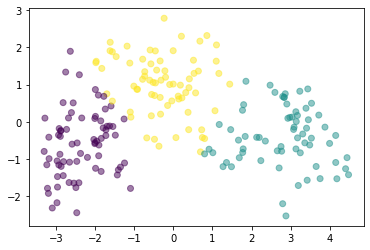

In [35]:
plt.scatter(x=pcacolmns[:,0],y=pcacolmns[:,1] , c= finalkmean.labels_, alpha=0.5)
plt.scatter(centroids, c='red')

In [36]:
bank_kmeans = bank
bank_kmeans['Cluster_Mapping'] = finalkmean.labels_
bank_kmeans.head(n=10)

,spending,advance_payments,probability_of_full_payment,current_balance,credit_limit,min_payment_amt,max_spent_in_single_shopping,Cluster_Mapping
0,19940.0,1692.0,0.8752,6675.0,37630.0,325.2,6550.0,1
1,15990.0,1489.0,0.9064,5363.0,35820.0,333.6,5144.0,2
2,18950.0,1642.0,0.8829,6248.0,37550.0,336.8,6148.0,1
3,10830.0,1296.0,0.8099,5278.0,26410.0,518.2,5185.0,0
4,17990.0,1586.0,0.8992,5890.0,36940.0,206.8,5837.0,1
5,12700.0,1341.0,0.8874,5183.0,30910.0,845.6,5000.0,0
6,12020.0,1333.0,0.8503,5350.0,28100.0,427.1,5308.0,0
7,13740.0,1405.0,0.8744,5482.0,31140.0,293.2,4825.0,2
8,18170.0,1626.0,0.8637,6271.0,35120.0,285.3,6273.0,1
9,11230.0,1288.0,0.8511,5140.0,27950.0,432.5,5003.0,0


#----------------Calculate the average of silhouette scores

In [29]:
silhouette_avg = silhouette_score(bankscaled, klabel)

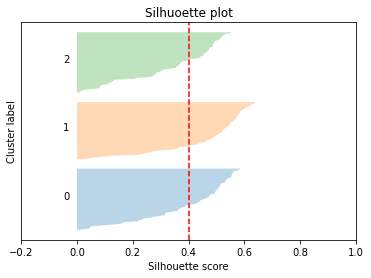

In [31]:
each_silhouette_score = silhouette_samples(bankscaled, klabel,metric="euclidean")
fig =plt.figure()
ax = fig.add_subplot(1,1,1)
y_lower =10

for i in range(0,3):
    ith_cluster_silhouette_values = each_silhouette_score[klabel == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,alpha=0.3)
    
    #label the silhouse plots with their cluster numbers at the middle
    ax.text(-0.05,y_lower + 0.5 * size_cluster_i,str(i))
    
    #compute the new y_lower for next plot
    y_lower = y_upper +10 
    
ax.set_title("Silhuoette plot")
ax.set_xlabel("Silhouette score")
ax.set_ylabel("Cluster label")
    
#the vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg,color="red",linestyle="--")
    
ax.set_yticks([])
ax.set_xticks([-0.2,0,0.2,0.4,0.6,0.8,1])

In [37]:
bank_kmeans['Cluster_Mapping'] = bank_kmeans['Cluster_Mapping'].astype(str) 
bank_kmeans['Cluster_Mapping'] = bank_kmeans['Cluster_Mapping'].replace(['0'],'Cluster1')
bank_kmeans['Cluster_Mapping'] = bank_kmeans['Cluster_Mapping'].replace(['1'],'Cluster2')
bank_kmeans['Cluster_Mapping'] = bank_kmeans['Cluster_Mapping'].replace(['2'],'Cluster3')
bank_kmeans['Cluster_Mapping'] = bank_kmeans['Cluster_Mapping'].astype('category')

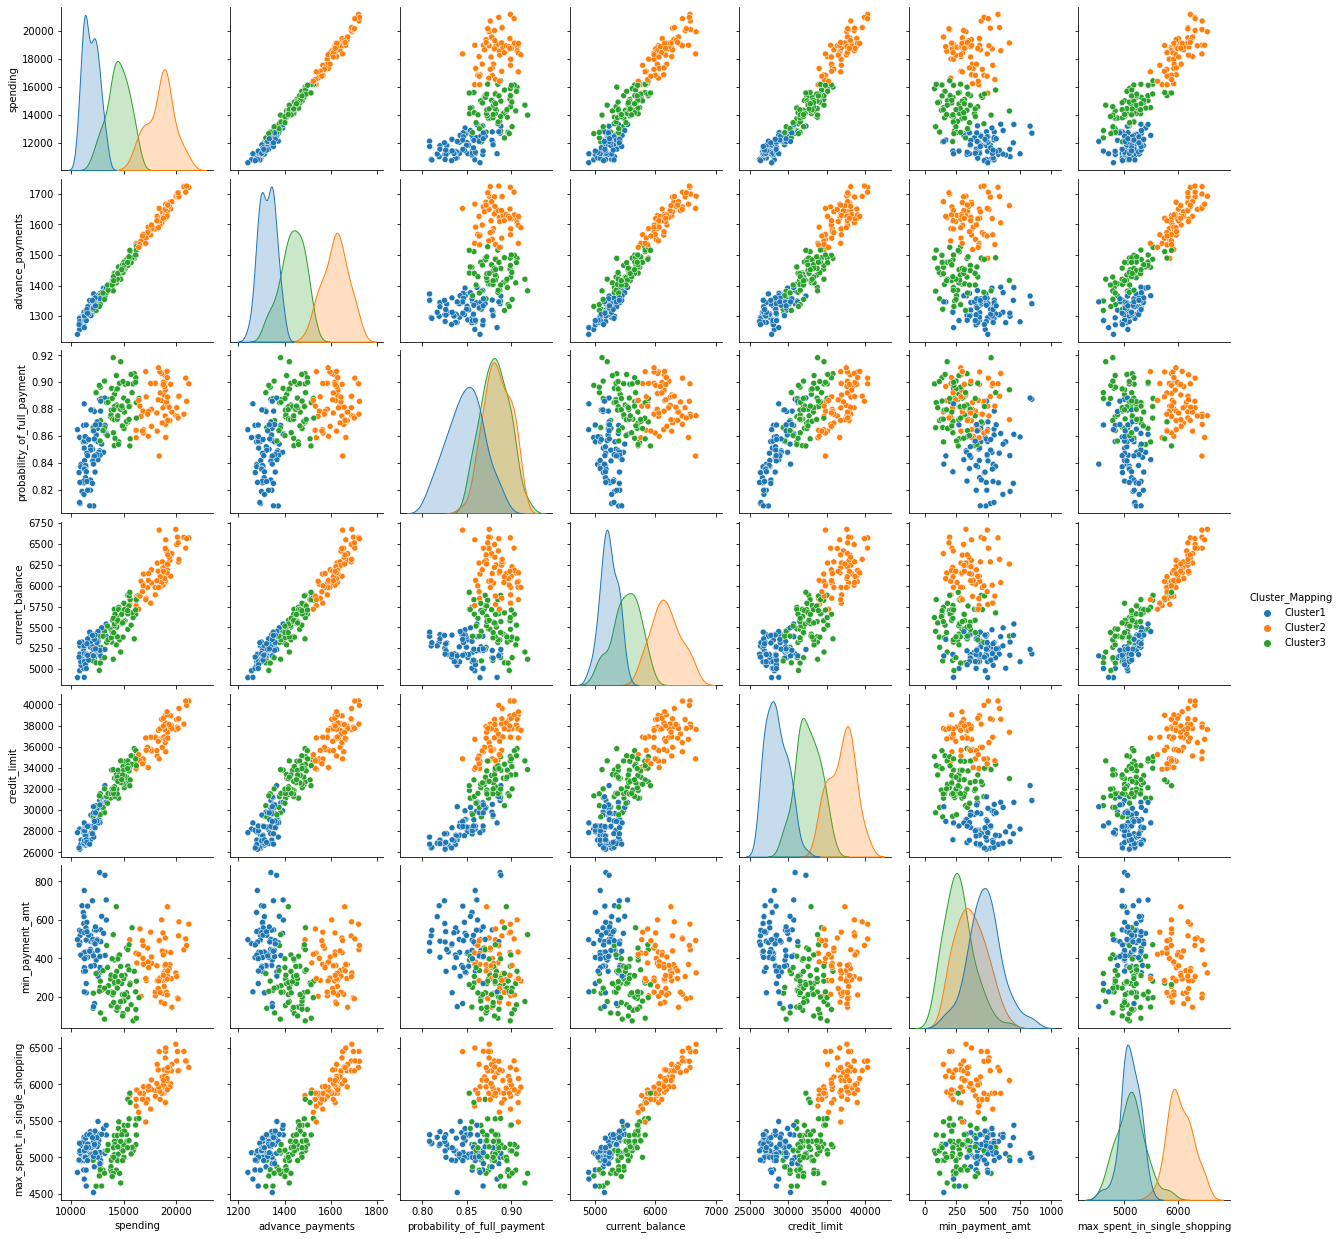

In [38]:
sns.pairplot(data=bank_kmeans,hue="Cluster_Mapping")